# Neuroevoluce

Pomocí evolučních algoritmů můžeme vyvíjet i celé neuronové sítě. Buď můžeme evolvovat váhy mezi neurony, strukturu sítě nebo obojí najednou. Nejprve se podíváme, jak naimplementovat jednoduchý algoritmus pro evoluci vah, následně si zkusíme i evoluci vah a struktury sítě najednou pomocí algoritmu NEAT.

## Evoluce vah

Evoluce vah je jednoduchá, stačí naimplementovat jednoduchou neuronovou síť, které umíme nastavit parametry. Náš jedinec v evoluci bude jeden dlouhý vektor, který bude reprezentovat váhy mezi vrstvami v neuronové síti. Při vyhodnocování tedy nastavíme síti váhy podle daného jedince a spočítáme její výstup. Zkusíme si tímto způsobem implementovat klasifikaci na našem oblíbeném datasetu iris.

In [1]:
import numpy as np

from sklearn import datasets, model_selection

from deap import algorithms, creator, base, cma, tools

Začneme tím, že si připravíme jednoduchou implementaci neuronové sítě. Při inicializaci nastavíme vrstvy, jejich velikosti a také jejich aktivace, jelikož každá vrstva může mít svou vlastní aktivační funkci.

Dále budeme potřebovat jednoho dlouhého linárního jedince všech vah rozdělit na váhové matice. To uděláme tak, že budeme brát vždy velikost akutální a následující vrstvy, na základě toho vezmeme odpovídající část jedince a vytvoříme z něj matici vah. Zároveň musíme přidat biasy, takže velikost aktuální vrstvy zvětšíme ještě o 1.

Nakonec bude potřeba ještě funkce pro evaluaci sítě, která vytvořenou síť vyhodnotí tak, že pro každou vrstvu použije odpovídající aktivaci a vrátí nám výstup sítě.

In [2]:
class NeuralNetwork: 
    def __init__(self, layer_sizes, activations):
        self.layer_sizes = layer_sizes
        self.layers = None

        # Checking, whether the number of activations corresponds to the number of layers
        if len(list(activations)) != len(layer_sizes) - 1:
            raise AttributeError("Number of activations does not match number of layers")
        
        self.activations = list(activations)
        self.vectorized_net = None


    # Returns total number of parameters of the network
    def vectorized_size(self):
        return sum(map(lambda x: (x[0] + 1) * x[1], zip(self.layer_sizes, self.layer_sizes[1:])))


    # Sets weights of the network using the values given by the linear individual
    def set_weights(self, vectorized_net):
        
        # Checking, whether the sizes match
        if len(vectorized_net) != self.vectorized_size():
            raise AttributeError(
                f"Length of vector does not match vectorized_size: {len(vectorized_net)} != {self.vectorized_size()}"
            )

        self.vectorized_net = vectorized_net
        self.layers = []
        sum_sizes = 0 # Sum of sizes of the previous layers (number of already processed elements)
        
        # Go through layers and set weight matrix between the current one and the following one
        # using the corresponding values from the linear indivudual.
        for (input_layer_size, output_layer_size) in zip(self.layer_sizes, self.layer_sizes[1:]):
            number_of_corresponding_elements = (input_layer_size + 1) * output_layer_size
            
            layer = vectorized_net[sum_sizes:(sum_sizes + number_of_corresponding_elements)]
            self.layers.append(np.reshape(layer, newshape=(input_layer_size + 1, output_layer_size))) # Reshaping to the correct format
            
            sum_sizes += number_of_corresponding_elements


    # Evaluation of the network
    def eval_network(self, inputs):
        activations = inputs
        
        for activation_function, layer in zip(self.activations, self.layers):
            activations_1 = np.append(np.array([1.0]), activations)  # Extending the input vector by a constant one to be multiplied by the bias part of the weights
            activations = activation_function(np.dot(activations_1, layer))

        return activations

Nyní si akorát načteme data a rozdělíme si je na trénovací a testovací.

In [3]:
iris = datasets.load_iris()
train_x, test_x, train_y, test_y = model_selection.train_test_split(iris.data, iris.target)

Musíme si ještě definovat fitness funkci, což bude pouze vyhodnocení sítě na datech, kdy vždy vybereme jako predikovanou třídu tu s maximální pravděpodobností a spočítáme pak celkovou accuracy. Zároveň si definujeme vlastní lineární a relu aktivace.

In [4]:
def relu(x):
    return np.maximum(0, x)

def linear(x):
    return x

def fitness(net, ind, X, y):
    net.set_weights(ind)
    
    acc = 0
    for xi, yi in zip(X, y):
        if np.argmax(net.eval_network(xi)) == yi:
            acc += 1
    
    return acc / len(y),

Pro samotné nastavení vah neuronové sítě použíjeme algoritmus CMA-ES, což je evoluční strategie, která je velmi dobrá na úlohy spojité optimalizace, kterou máme i zde. V evoluční strategii se většinou nevyskytuje křížení, ale místo něj se klade důraz na mutaci. Zde se používá námi známá gaussovská mutace. CMA-ES funguje tak dobře proto, že nám umožňuje váhy měnit korelovaně, protože si pamatuje celou kovariační matici, ze které generuje jedince. Klasická evoluce umí měnit váhy jen nezávisle na sobě, a dává proto horší výsledky. CMA-ES je implementována v knihovně deap, a je tedy snadné ji použít.

In [5]:
net = NeuralNetwork([4, 5, 3], [relu, linear])
ind_size = net.vectorized_size()    
    
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("evaluate", lambda ind, X, y: fitness(net, ind, X, y), X=train_x, y=train_y)

strategy = cma.Strategy(centroid=[0.0] * ind_size, sigma=0.1, lambda_= 5 * ind_size)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

_ = algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof)

gen	nevals	avg     	std      	min	max     
0  	215   	0.336503	0.0915334	0  	0.696429
1  	215   	0.35407 	0.0992462	0  	0.696429
2  	215   	0.361503	0.118657 	0  	0.696429
3  	215   	0.361088	0.0978588	0  	0.696429
4  	215   	0.383306	0.120459 	0  	0.696429
5  	215   	0.380565	0.133606 	0  	0.901786
6  	215   	0.38941 	0.133571 	0  	0.714286
7  	215   	0.389244	0.132698 	0  	0.696429
8  	215   	0.395847	0.130639 	0  	0.696429
9  	215   	0.417899	0.148542 	0  	0.785714
10 	215   	0.430066	0.147686 	0.0803571	0.883929
11 	215   	0.422633	0.159166 	0        	0.9375  
12 	215   	0.431894	0.159275 	0        	0.741071
13 	215   	0.459801	0.166036 	0.0178571	0.964286
14 	215   	0.475291	0.175315 	0.0178571	0.964286
15 	215   	0.458679	0.167298 	0.00892857	0.955357
16 	215   	0.48397 	0.167374 	0.1875    	0.982143
17 	215   	0.471512	0.175151 	0         	0.839286
18 	215   	0.475914	0.172981 	0.0267857 	0.964286
19 	215   	0.478447	0.169902 	0.00892857	0.857143
20 	215   	0.496595	0.190643 	0 

Na závěr si zkusíme otestovat síť na testovacích datech a změřit na nich accuracy.

In [7]:
accuracy = fitness(net, hof[0], test_x, test_y)[0]
print("Achieved accuracy:", accuracy)

Achieved accuracy: 0.9473684210526315


## NEAT

Zkusíme se podívat na algoritmus NEAT na příkladu s datasetem iris a zkusíme pro něj najít co nejvhodnější síť, která bude umět data pokud možno co nejlépe klasifikovat. Samotná implementace algorimtu není vůbec jednoduchá, ale naštěstí v pythonu existuje knihovna neat-python, kde už tu práci někdo udělal za nás (instalujeme pomocí `pip install neat-python`). Knihovna má trochu jiný interface, než na co jsme zvyklí, ale není složité se jí naučit používat. Nastavení parametrů algoritmu se načítá ze zvláštního souboru *config-feedforward*. Dokumentace k jeho formátování se nachází [zde](https://neat-python.readthedocs.io/en/latest/config_file.html). Potom už stačí jen algoritmus spustit. Níže uvedený příklad vychází z dokumentace k [neat-python](https://github.com/CodeReclaimers/neat-python/tree/master/examples/xor) upravený pro naši klasifikaci irisů.

In [8]:
import neat
import visualize

In [9]:
# Construction and evaluation of a network in NEAT - basically a fitness function
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0.0
        net = neat.nn.FeedForwardNetwork.create(genome, config) 
        
        for xi, xo in zip(train_x, train_y): 
            output = net.activate(xi)
            if np.argmax(output) == xo:
                genome.fitness += 1

In [10]:
# Path to the configuration file
config_path = "config-feedforward"

# Load NEAT configuration
config = neat.Config(
    neat.DefaultGenome,
    neat.DefaultReproduction,
    neat.DefaultSpeciesSet,
    neat.DefaultStagnation,
    config_path
)

# Create new population
population = neat.Population(config)

# Add statistics computation for evolution logging
population.add_reporter(neat.StdOutReporter(show_species_detail=True))
stats = neat.StatisticsReporter()
population.add_reporter(stats)

# Run for a given number of generations
winner = population.run(eval_genomes, 100)


 ****** Running generation 0 ****** 

Population's average fitness: 36.76000 stdev: 14.33582
Best fitness: 78.00000 - size: (3, 12) - species 1 - id 99
Average adjusted fitness: 0.471
Mean genetic distance 1.164, standard deviation 0.262
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150     78.0    0.471     0
Total extinctions: 0
Generation time: 0.398 sec

 ****** Running generation 1 ****** 

Population's average fitness: 44.19333 stdev: 15.96275
Best fitness: 78.00000 - size: (3, 12) - species 1 - id 99
Average adjusted fitness: 0.567
Mean genetic distance 1.230, standard deviation 0.296
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150     78.0    0.567     1
Total extinctions: 0
Generation time: 0.537 sec (0.467 average)

 ****** Running generation 2 ****** 

Population's average fitness: 44.36667 

*Best genome*
Key: 8071
Fitness: 110.0
Nodes:
	0 DefaultNodeGene(key=0, bias=-2.8789186478703446, response=1.0, activation=sigmoid, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.9318874845306646, response=1.0, activation=sigmoid, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=-2.7774474147125447, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-4, 0), weight=-2.7704077398999507, enabled=False)
	DefaultConnectionGene(key=(-4, 2), weight=0.8349235258363109, enabled=True)
	DefaultConnectionGene(key=(-3, 0), weight=-4.488294312841766, enabled=True)
	DefaultConnectionGene(key=(-3, 2), weight=4.8206823710907125, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=4.993398984059911, enabled=True)
	DefaultConnectionGene(key=(-2, 1), weight=0.7108918650864628, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=1.1697183096576305, enabled=False)
	DefaultConnectionGene(key=(-1, 2), weight=-3.08763956961993, enabled=True)

Total accuracy 

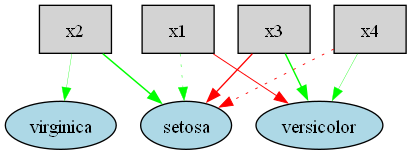

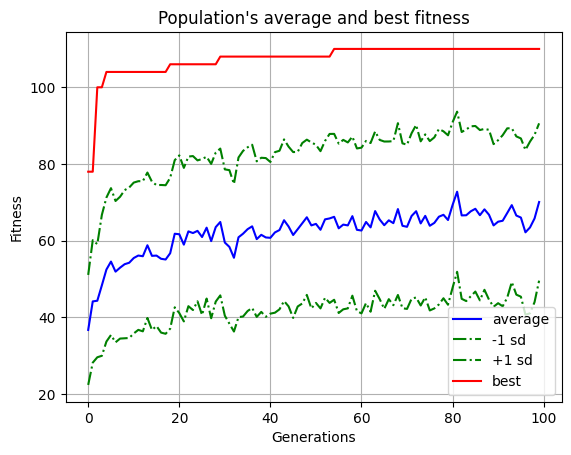

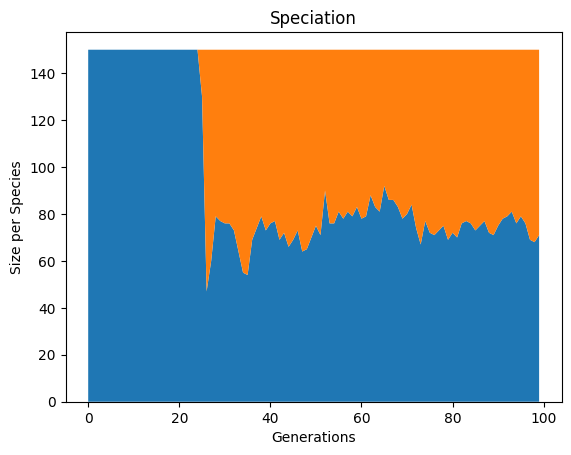

In [11]:
# Show the best individual and its accuracy on test data
print(f"*Best genome*\n{winner}")

winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
num_of_correct_predictions = 0
for input_example, correct_output in zip(test_x, test_y):
    output = winner_net.activate(input_example)
    prediction = np.argmax(output)
        
    if prediction == correct_output:
        num_of_correct_predictions += 1
    
print("\nTotal accuracy on the test data:", num_of_correct_predictions / len(test_y))

# Render the best network
node_names = {-1:"x1", -2: "x2", -3: "x3", -4: "x4", 0:"setosa", 1:"virginica", 2:"versicolor"}
visualize.draw_net(
    config,
    genome=winner,
    node_names=node_names,
    show_disabled=True,
    prune_unused=False
) 

# Plot the statistics
visualize.plot_stats(stats, ylog=False, view=True)
visualize.plot_species(stats, view=True)

## Domácí úkol - Zpětnovazební učení s využitím neuroevoluce

Za domácí úkol budete mít vyzkoušet si vyřešit některá prostředí z knihovny [Gymnasium](https://gymnasium.farama.org/). Vyzkoušet můžete buď NEAT (v takovém případě můžete použít třeba knihovnu, kterou jsme si právě vyzkoušeli, jen nezapomeňte přizpůsobit konfigurační soubor, fitness a tak podobně), vyvíjet jen vektor vah fixní sítě, nebo cokoli vás napadne.

[Detailní zadání](https://kam.mff.cuni.cz/~lorenc/teach/PIA_hw/homeworks-neuroevolution.html) je možno najít na stránkách cvičení.
